# TD4 - Explainability AI

#### Matias OTTENSEN
#### Tiphaine KACHKACHI
#### Manon GARDIN

# Our dataset 

Petite description du dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import sklearn
from sklearn.datasets import load_diabetes

In [2]:
df = pd.read_csv('archive/US_Accidents_March23.csv', sep=',')

## Observe data

In [3]:
df.shape

(7728394, 46)

We have a great number of lines in our dataset.\
Also we have 46 columns, we probably won't need every one of them. Let's see their name :

In [4]:
df.columns

Index(['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
       'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description',
       'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

In [5]:
df.head(10)

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,True,False,Day,Day,Day,Day
5,A-6,Source2,3,2016-02-08 07:44:26,2016-02-08 08:14:26,40.100590,-82.925194,NaN,NaN,0.01,...,False,False,False,False,False,False,Day,Day,Day,Day
6,A-7,Source2,2,2016-02-08 07:59:35,2016-02-08 08:29:35,39.758274,-84.230507,NaN,NaN,0.00,...,False,False,False,False,False,False,Day,Day,Day,Day
7,A-8,Source2,3,2016-02-08 07:59:58,2016-02-08 08:29:58,39.770382,-84.194901,NaN,NaN,0.01,...,False,False,False,False,False,False,Day,Day,Day,Day
8,A-9,Source2,2,2016-02-08 08:00:40,2016-02-08 08:30:40,39.778061,-84.172005,NaN,NaN,0.00,...,False,False,False,False,False,False,Day,Day,Day,Day
9,A-10,Source2,3,2016-02-08 08:10:04,2016-02-08 08:40:04,40.100590,-82.925194,NaN,NaN,0.01,...,False,False,False,False,False,False,Day,Day,Day,Day


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Data columns (total 46 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Source                 object 
 2   Severity               int64  
 3   Start_Time             object 
 4   End_Time               object 
 5   Start_Lat              float64
 6   Start_Lng              float64
 7   End_Lat                float64
 8   End_Lng                float64
 9   Distance(mi)           float64
 10  Description            object 
 11  Street                 object 
 12  City                   object 
 13  County                 object 
 14  State                  object 
 15  Zipcode                object 
 16  Country                object 
 17  Timezone               object 
 18  Airport_Code           object 
 19  Weather_Timestamp      object 
 20  Temperature(F)         float64
 21  Wind_Chill(F)          float64
 22  Humidity(%)       

As the dataframe is huge (almost 3 gb), we decided to work on another version of this dataframe, just to have a sample that we could work on esier:

Variables like Street, City, Zipcode and County won't be useful to keep, because there are too many distinct values.\
The columns Bump, Traffic_calming, Turning_loop, Give_Way, No_Exit, Roundabout can be deleted because they take only one value (all false).\
The variable Country only takes US so we can delete it.\
We can also delete some columns like Airport_Code that won't be relevant.

In [7]:
# Delete the columns we don't need 
df = df.drop(['Street', 'City', 'Description','County', 'Zipcode', 'Country', 'Bump', 'Traffic_Calming', 'Turning_Loop', 'Give_Way', 'No_Exit', 'Roundabout', 'Airport_Code'], axis=1)

In [8]:
df.head(10)

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Crossing,Junction,Railway,Station,Stop,Traffic_Signal,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,False,True,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,False,True,Day,Day,Day,Day
5,A-6,Source2,3,2016-02-08 07:44:26,2016-02-08 08:14:26,40.100590,-82.925194,NaN,NaN,0.01,...,False,False,False,False,False,False,Day,Day,Day,Day
6,A-7,Source2,2,2016-02-08 07:59:35,2016-02-08 08:29:35,39.758274,-84.230507,NaN,NaN,0.00,...,False,False,False,False,False,False,Day,Day,Day,Day
7,A-8,Source2,3,2016-02-08 07:59:58,2016-02-08 08:29:58,39.770382,-84.194901,NaN,NaN,0.01,...,False,False,False,False,False,False,Day,Day,Day,Day
8,A-9,Source2,2,2016-02-08 08:00:40,2016-02-08 08:30:40,39.778061,-84.172005,NaN,NaN,0.00,...,False,False,False,False,False,False,Day,Day,Day,Day
9,A-10,Source2,3,2016-02-08 08:10:04,2016-02-08 08:40:04,40.100590,-82.925194,NaN,NaN,0.01,...,False,False,False,False,False,False,Day,Day,Day,Day


In [9]:
df.describe

<bound method NDFrame.describe of                 ID   Source  Severity           Start_Time  \
0              A-1  Source2         3  2016-02-08 05:46:00   
1              A-2  Source2         2  2016-02-08 06:07:59   
2              A-3  Source2         2  2016-02-08 06:49:27   
3              A-4  Source2         3  2016-02-08 07:23:34   
4              A-5  Source2         2  2016-02-08 07:39:07   
...            ...      ...       ...                  ...   
7728389  A-7777757  Source1         2  2019-08-23 18:03:25   
7728390  A-7777758  Source1         2  2019-08-23 19:11:30   
7728391  A-7777759  Source1         2  2019-08-23 19:00:21   
7728392  A-7777760  Source1         2  2019-08-23 19:00:21   
7728393  A-7777761  Source1         2  2019-08-23 18:52:06   

                    End_Time  Start_Lat   Start_Lng   End_Lat    End_Lng  \
0        2016-02-08 11:00:00  39.865147  -84.058723       NaN        NaN   
1        2016-02-08 06:37:59  39.928059  -82.831184       NaN        

# Data Cleaning

Missing values:

In [10]:
print(df.isnull().sum())

ID                             0
Source                         0
Severity                       0
Start_Time                     0
End_Time                       0
Start_Lat                      0
Start_Lng                      0
End_Lat                  3402762
End_Lng                  3402762
Distance(mi)                   0
State                          0
Timezone                    7808
Weather_Timestamp         120228
Temperature(F)            163853
Wind_Chill(F)            1999019
Humidity(%)               174144
Pressure(in)              140679
Visibility(mi)            177098
Wind_Direction            175206
Wind_Speed(mph)           571233
Precipitation(in)        2203586
Weather_Condition         173459
Amenity                        0
Crossing                       0
Junction                       0
Railway                        0
Station                        0
Stop                           0
Traffic_Signal                 0
Sunrise_Sunset             23246
Civil_Twil

There are missing values, so, what can we do about it?

First, we create a new dataframe to secure the first one if we ever delete the wring values

In [11]:
newdf = df

We had to make a choice for each column on how to handle the missing values. We chose to keep every missing values, we did not delete any rows. We preferred to replace them with values that are easily readable for string values, and to use the average for the numerical values.

In [12]:
#for the end lat/lng : we will fill the NAN by the start lat/lng:

newdf['End_Lat']=newdf['End_Lat'].fillna(newdf['Start_Lat'])
newdf['End_Lng']=newdf['End_Lng'].fillna(newdf['Start_Lng'])

#for the streets/Cities/Description/timezone/Weather_Condition/Sunrise_Sunset/Civil_Twilight/Nautical_Twilight
#and Astronomical_Twilight, we just write "unknown", 
#as we do not want to give fake informations to the person reading

newdf['Timezone']=newdf['Timezone'].fillna('unknown')
newdf['Weather_Condition']=newdf['Weather_Condition'].fillna('unknown')
newdf['Sunrise_Sunset']=newdf['Sunrise_Sunset'].fillna('unknown')
newdf['Civil_Twilight']=newdf['Civil_Twilight'].fillna('unknown')
newdf['Nautical_Twilight']=newdf['Weather_Condition'].fillna('unknown')
newdf['Astronomical_Twilight']=newdf['Astronomical_Twilight'].fillna('unknown')

# for the weather timestamp, we put now's date
newdf['Weather_Timestamp']=newdf['Weather_Timestamp'].fillna(datetime.now())

newdf = newdf.dropna(subset=['Precipitation(in)'])
newdf = newdf.dropna(subset=['Temperature(F)'])
newdf = newdf.dropna(subset=['Wind_Chill(F)'])
newdf = newdf.dropna(subset=['Pressure(in)'])
newdf = newdf.dropna(subset=['Humidity(%)'])
newdf = newdf.dropna(subset=['Visibility(mi)'])
newdf = newdf.dropna(subset=['Wind_Speed(mph)'])

# for the airport code, we write '###' in the missing values
newdf['Wind_Direction']=newdf['Wind_Direction'].fillna('###')

In [13]:
print(newdf.isnull().sum())

ID                       0
Source                   0
Severity                 0
Start_Time               0
End_Time                 0
Start_Lat                0
Start_Lng                0
End_Lat                  0
End_Lng                  0
Distance(mi)             0
State                    0
Timezone                 0
Weather_Timestamp        0
Temperature(F)           0
Wind_Chill(F)            0
Humidity(%)              0
Pressure(in)             0
Visibility(mi)           0
Wind_Direction           0
Wind_Speed(mph)          0
Precipitation(in)        0
Weather_Condition        0
Amenity                  0
Crossing                 0
Junction                 0
Railway                  0
Station                  0
Stop                     0
Traffic_Signal           0
Sunrise_Sunset           0
Civil_Twilight           0
Nautical_Twilight        0
Astronomical_Twilight    0
dtype: int64


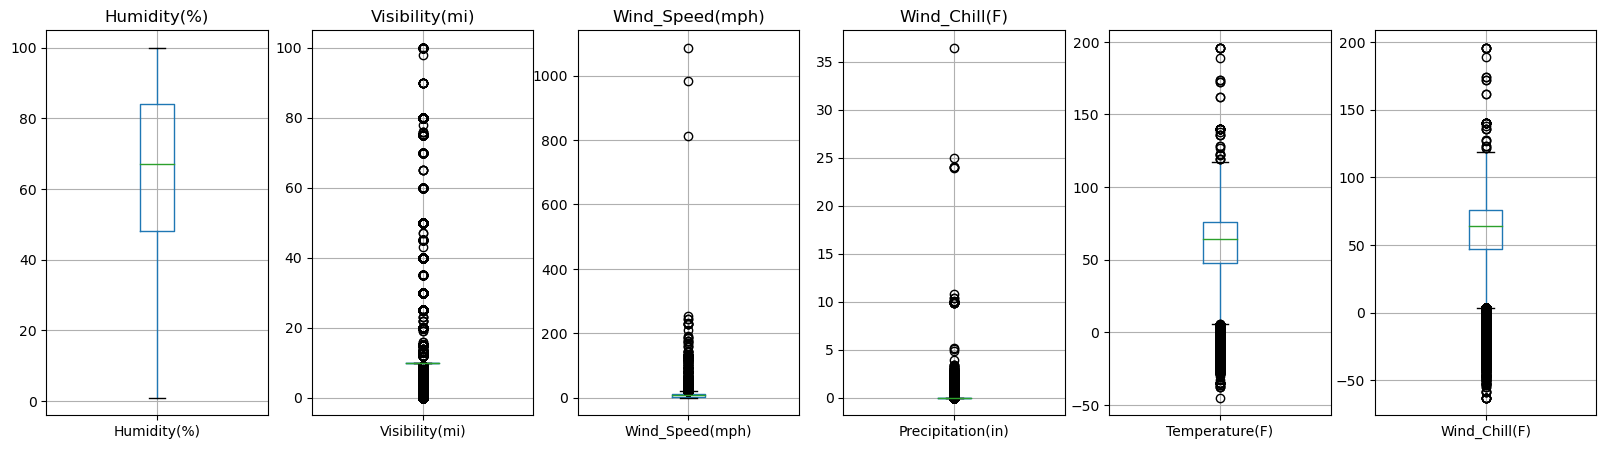

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(20, 5))

newdf[['Humidity(%)']].boxplot(ax=axes[0])
axes[0].set_title('Humidity(%)')

newdf[['Visibility(mi)']].boxplot(ax=axes[1])
axes[1].set_title('Visibility(mi)')

newdf[['Wind_Speed(mph)']].boxplot(ax=axes[2])
axes[2].set_title('Wind_Speed(mph)')

newdf[['Precipitation(in)']].boxplot(ax=axes[3])
axes[3].set_title('Precipitation(in)')

newdf[['Temperature(F)']].boxplot(ax=axes[4])
axes[3].set_title('Temperature(F)')

newdf[['Wind_Chill(F)']].boxplot(ax=axes[5])
axes[3].set_title('Wind_Chill(F)')

plt.show()

as we can see, there are a lot of outliers in the dataset, we chose to keep a certain amount of them, and to delete the rest.

As we can see for example in the visibility plot, there is a huge amount of "10" values, so the other values are more rare, so we can decide to keep it this way or to delete them. We chose not to delete everyone of them.

In [15]:
#Visibility 
newdf.loc[newdf['Visibility(mi)'] > 60, 'Visibility(mi)'] = 60

#Wind speed
newdf = newdf[newdf['Wind_Speed(mph)'] <= 400]

#precipitaion
newdf = newdf[newdf['Precipitation(in)'] <= 7]

#Temperature
Q1= newdf['Temperature(F)'].quantile(0.25)
Q3= newdf['Temperature(F)'].quantile(0.75)
IQR = Q3 - Q1

max_limit = Q3 + (1.5 * IQR)
min_limit = Q1 - (1.5 * IQR)

newdf.loc[(df['Temperature(F)'] < min_limit), 'Temperature(F)'] = min_limit
newdf.loc[(df['Temperature(F)'] > max_limit), 'Temperature(F)'] = max_limit

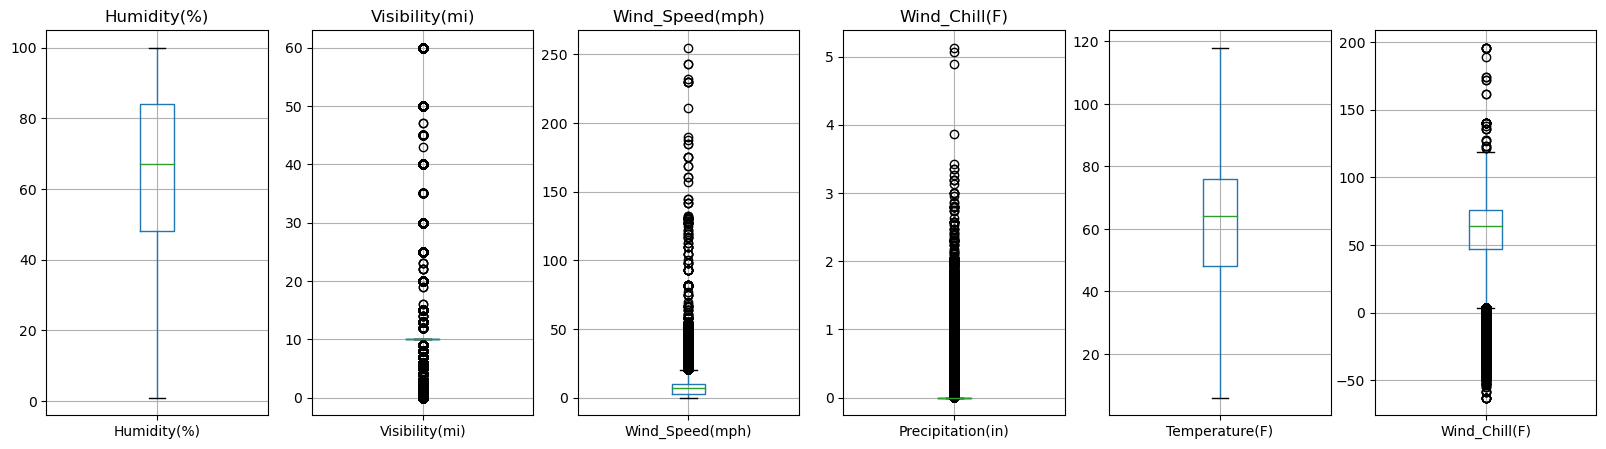

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(20, 5))

newdf[['Humidity(%)']].boxplot(ax=axes[0])
axes[0].set_title('Humidity(%)')

newdf[['Visibility(mi)']].boxplot(ax=axes[1])
axes[1].set_title('Visibility(mi)')

newdf[['Wind_Speed(mph)']].boxplot(ax=axes[2])
axes[2].set_title('Wind_Speed(mph)')

newdf[['Precipitation(in)']].boxplot(ax=axes[3])
axes[3].set_title('Precipitation(in)')

newdf[['Temperature(F)']].boxplot(ax=axes[4])
axes[3].set_title('Temperature(F)')

newdf[['Wind_Chill(F)']].boxplot(ax=axes[5])
axes[3].set_title('Wind_Chill(F)')

plt.show()

In [17]:
halfsize=int((newdf.shape[0])/80)
newdf = newdf.iloc[:halfsize,:]
print(newdf.shape)
newdf.reset_index(drop=True, inplace=True)

(65584, 33)


In [18]:
print(newdf['Precipitation(in)'])

0        0.03
1        0.02
2        0.02
3        0.02
4        0.01
         ... 
65579    0.00
65580    0.00
65581    0.00
65582    0.00
65583    0.00
Name: Precipitation(in), Length: 65584, dtype: float64


# Question 3

The variables we can predict are probably the severity of an accident, and maybe a start time.

Based on our intuition, we think that the most important variables to predict the severity of an accident would be the weather condition variables like Humidity, Wind Speed, Pressure, etc. And probably the time of the day like Day or Night.

## Univariate Analysis

Let's do a histogram

(array([16927.,     0.,     0., 25157.,     0.,     0., 23171.,     0.,
            0.,   329.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

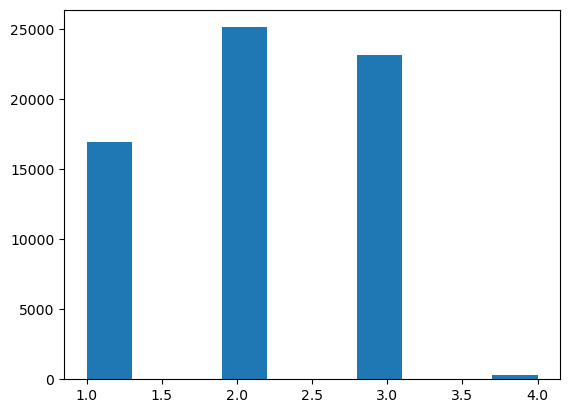

In [19]:
plt.hist(newdf['Severity'])

(array([50460.,     0.,     0.,     0.,     0., 14760.,     0.,     0.,
            0.,   364.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

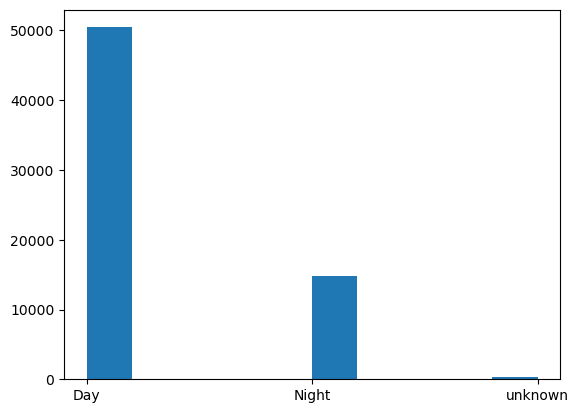

In [20]:
plt.hist(newdf['Sunrise_Sunset'])

(array([  192.,  1209.,  2256.,  3587.,  5660.,  7079.,  8292.,  9607.,
        14489., 13213.]),
 array([  1. ,  10.9,  20.8,  30.7,  40.6,  50.5,  60.4,  70.3,  80.2,
         90.1, 100. ]),
 <BarContainer object of 10 artists>)

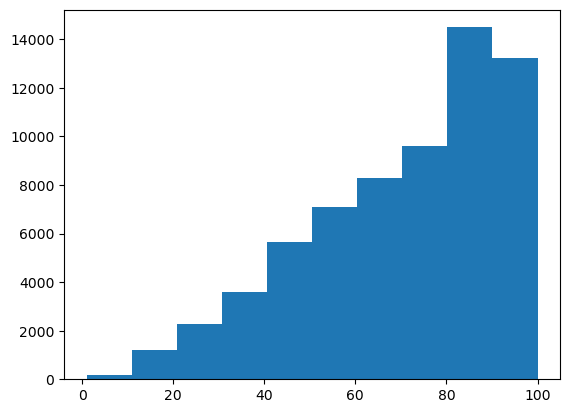

In [21]:
plt.hist(newdf['Humidity(%)'])

(array([2.7000e+01, 7.2500e+02, 9.4100e+02, 1.4690e+03, 6.0432e+04,
        1.9890e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([20.98 , 22.827, 24.674, 26.521, 28.368, 30.215, 32.062, 33.909,
        35.756, 37.603, 39.45 ]),
 <BarContainer object of 10 artists>)

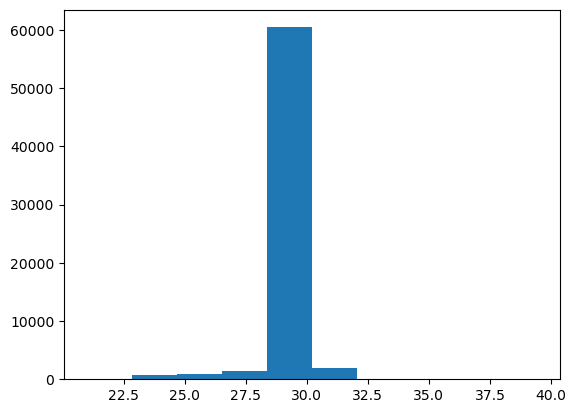

In [22]:
plt.hist(newdf['Pressure(in)'])

As we can see, in most case, there is high humidity, more, accidents with 0% humidity are very rare according to the histogram.
Most accidents happen with 7.5 mph, during the day, with a 30/35 in of pressure.

## Bivariate Analysis

Let's do some correlation matrices to understand which variables are the most impactful on the severity.

<Axes: >

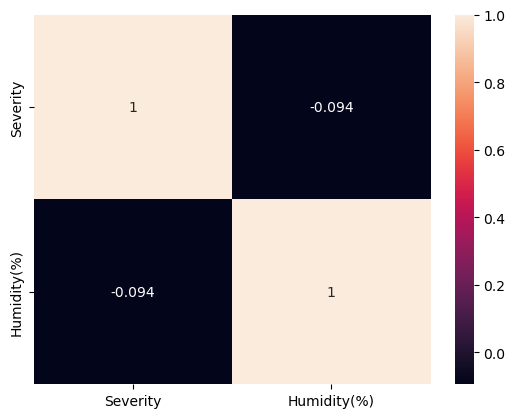

In [23]:
correl1 = newdf.loc[:, ['Severity', 'Humidity(%)']]
corr_matrix = correl1.corr()
sns.heatmap(corr_matrix, annot=True)

<Axes: >

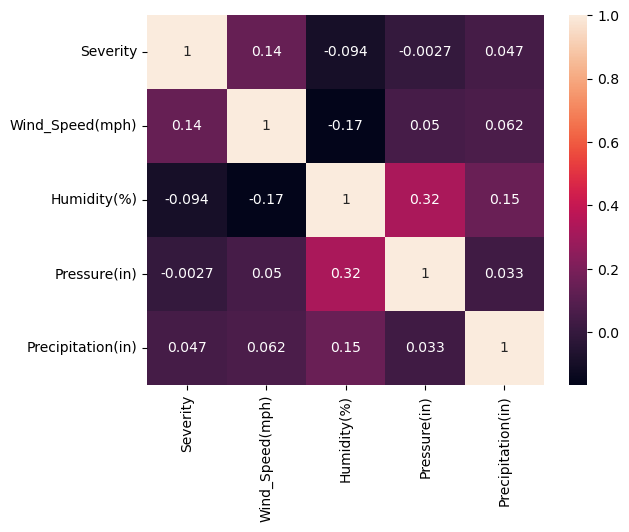

In [24]:
correl1 = newdf.loc[:, ['Severity', 'Wind_Speed(mph)','Humidity(%)','Pressure(in)', 'Precipitation(in)']]
corr_matrix = correl1.corr()
sns.heatmap(corr_matrix, annot=True)

So we can here see the correlation between the severity and the other chosen quantitative variable. The highest are the precipitation and the wind speed.

# Question 4

Here we are going to do a linear regression to predict values of new data for the dataset. 
Based on our intuition, we think that the most important variables to predict the severity of an accident would be the weather condition variables like Humidity or the time of the day like Day or Night, or even where it happened (what is on a stop, or a traffic sign ?)...


In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [26]:
newdf.info() #We check again which colomns we have and their type 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65584 entries, 0 to 65583
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     65584 non-null  object 
 1   Source                 65584 non-null  object 
 2   Severity               65584 non-null  int64  
 3   Start_Time             65584 non-null  object 
 4   End_Time               65584 non-null  object 
 5   Start_Lat              65584 non-null  float64
 6   Start_Lng              65584 non-null  float64
 7   End_Lat                65584 non-null  float64
 8   End_Lng                65584 non-null  float64
 9   Distance(mi)           65584 non-null  float64
 10  State                  65584 non-null  object 
 11  Timezone               65584 non-null  object 
 12  Weather_Timestamp      65584 non-null  object 
 13  Temperature(F)         65584 non-null  float64
 14  Wind_Chill(F)          65584 non-null  float64
 15  Hu

In [27]:
# Define target variable and predictor variables
X = newdf[['Visibility(mi)','Weather_Condition','Crossing','Junction','Station','Traffic_Signal','Stop','State','Precipitation(in)']] 
y = newdf['Severity']

After many test, to see which variables we should tale we decided to go with variable containing location informations (stop, state, traffic_signal...), variables linked to the condition (visibility, weather condition...).

In [28]:
# hot encoding on 'Weather_Condition' and 'State' columns as they are string colomns
X_encoded = pd.get_dummies(X, columns=['Weather_Condition','State'], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [29]:
# Fit the linear regression model on the encoded data
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [30]:
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print("Training R^2 score:", train_score)
print("Testing R^2 score:", test_score)

# Where a higher value indicates a better fit of the model to the data.

Training R^2 score: 0.24226888003767255
Testing R^2 score: 0.2350560431030556


We got a Training R^2 score of around 0.24. Knowing that the training R^2 score measures how well the model fits the training data. A high training R^2 score indicates that the model explains a large proportion of the variance in the training data.

The testing R^2 score (here 0.23) measures how well the model generalizes to new, unseen data. This is crucial because the ultimate goal of a machine learning model is to make accurate predictions on new data. Here we have a lower testing score then a training score, while still behind close in value. Having a much higher testing score indicates overfitting.

Like we said earlier we tested the model with many differents variables to see which had the biggest impact on the dataset, and this is the combination that made us have the highest score for both the training and the testing score. Still, the number for both training and testing are very low (as it variates between 0 and 1). This may indicated us that the model is underfitting, meaning it's too simplistic. We can deduce that it's not explaining much of the variance in the data overall, this may be because there are so many variables, they don't have much significance overall on the dataset...

In [31]:
#Now we can get the coefficients
coefficients = model.coef_
intercept = model.intercept_

In [32]:
# Here we display all coefficients 
print("Intercept:", intercept)
for i, variable in enumerate(X_encoded.columns):
    print(f"Coefficient for {variable}: {coefficients[i]}")

Intercept: 1.987331001523219
Coefficient for Visibility(mi): 0.008294440440957866
Coefficient for Crossing: -0.241358631113939
Coefficient for Junction: 0.2126979341210223
Coefficient for Station: -0.26108284820181643
Coefficient for Traffic_Signal: -0.42914946906940815
Coefficient for Stop: -0.47452637096300226
Coefficient for Precipitation(in): 0.07488218293126508
Coefficient for Weather_Condition_Blowing Snow: -0.03326801311579436
Coefficient for Weather_Condition_Clear: 0.4477355145161282
Coefficient for Weather_Condition_Cloudy: 0.15721486859751227
Coefficient for Weather_Condition_Cloudy / Windy: 0.06547604808421903
Coefficient for Weather_Condition_Drizzle: 0.2573572132264398
Coefficient for Weather_Condition_Drizzle and Fog: -1.27675647831893e-15
Coefficient for Weather_Condition_Fair: 0.12263446382224921
Coefficient for Weather_Condition_Fair / Windy: 0.2519564879913234
Coefficient for Weather_Condition_Fog: 0.04611991494938203
Coefficient for Weather_Condition_Haze: 0.3011899

Our intercept value is of 0.785 approximatly. This means when all of our independent variables are zero, the model predicts that the value of the Severity will be around 0.785.

As we can see, there are so many variables, all of the coefficients are, in the end, very low. A coefficient close to zero suggests that the presence or absence of drifting snow as a weather condition has almost no impact on the Severity of accidents. As there are many coefficient, to see a little bit better we can display only the one that interest us by choosing value bigger then a number, like so :

In [33]:
# We display all coefficients with a high number = high impact on Severity
print("Intercept:", intercept)
for i, variable in enumerate(X_encoded.columns):
    if abs(coefficients[i]) > 0.5:
        print(f"Coefficient for {variable}: {coefficients[i]}")

Intercept: 1.987331001523219
Coefficient for Weather_Condition_Heavy Drizzle: 0.6184802621090683
Coefficient for Weather_Condition_Heavy Ice Pellets: 0.9461044564253154
Coefficient for Weather_Condition_Heavy Snow: 0.5346557025067604
Coefficient for Weather_Condition_Ice Pellets: 0.5033501618930664
Coefficient for Weather_Condition_Light Freezing Drizzle: 0.5504535628707807
Coefficient for Weather_Condition_Light Freezing Fog: 0.7190285534587425
Coefficient for Weather_Condition_Light Freezing Rain: 0.5410180387148352
Coefficient for Weather_Condition_Light Ice Pellets: 0.6747075055707125
Coefficient for Weather_Condition_Light Rain Showers: 0.5026463746744028
Coefficient for Weather_Condition_Light Rain with Thunder: 0.5176337179641906
Coefficient for Weather_Condition_Light Thunderstorms and Rain: 0.5908249583395023
Coefficient for Weather_Condition_Light Thunderstorms and Snow: 1.10134845154846
Coefficient for Weather_Condition_Snow: 0.5032706296503984
Coefficient for Weather_Condit

As we can see, some weather condition have a bigger impact on the Severity than others (Thunderstorms and Snow/rain) seems to be the highest. It is logical. Some state also harbor bigger coefficients than other like the WY State with a huge coefficient of 1.85. 

Now let's display low-impact coefficients.

In [34]:
# We display all coefficient with a low number = low impact on Severity
for i, variable in enumerate(X_encoded.columns):
    if abs(coefficients[i]) < 0.1:
        print(f"Coefficient for {variable}: {coefficients[i]}")

Coefficient for Visibility(mi): 0.008294440440957866
Coefficient for Precipitation(in): 0.07488218293126508
Coefficient for Weather_Condition_Blowing Snow: -0.03326801311579436
Coefficient for Weather_Condition_Cloudy / Windy: 0.06547604808421903
Coefficient for Weather_Condition_Drizzle and Fog: -1.27675647831893e-15
Coefficient for Weather_Condition_Fog: 0.04611991494938203
Coefficient for Weather_Condition_Heavy Freezing Rain: -0.07211461238552788
Coefficient for Weather_Condition_Heavy Thunderstorms and Snow: -5.0584536559483695e-15
Coefficient for Weather_Condition_Light Snow / Windy: -1.7340295865864164e-14
Coefficient for Weather_Condition_Mist: 0.0838200568825255
Coefficient for Weather_Condition_Shallow Fog: 0.051363793609885015
Coefficient for State_AR: -0.06676862256370578
Coefficient for State_AZ: -0.07016253780492973
Coefficient for State_CA: -0.04539208461057674
Coefficient for State_ID: -9.325873406851315e-15
Coefficient for State_IL: 0.0965996513790763
Coefficient for S

The results are a bit surprising as we could think Visibility(mi), Wind_Speed(mph) or Precipitation(in)could have a bigger impact on the Severity, however it is not the case. A lot of weather condition also have a low impact, but this could be because there is not enought data with all these types of weather. As we can see above, weather does have an impact on the severity. We would have also though that Crossing, Junction and Station had bigger coefficient overall.

It could be interesting to see which coefficients have a medium impact (between 0.1 and 0.5).

In [35]:
# We display all coefficient with a medium number = medium impact on Severity
for i, variable in enumerate(X_encoded.columns):
    if 0.1 <= abs(coefficients[i]) <= 0.5:
        print(f"Coefficient for {variable}: {coefficients[i]}")

Coefficient for Crossing: -0.241358631113939
Coefficient for Junction: 0.2126979341210223
Coefficient for Station: -0.26108284820181643
Coefficient for Traffic_Signal: -0.42914946906940815
Coefficient for Stop: -0.47452637096300226
Coefficient for Weather_Condition_Clear: 0.4477355145161282
Coefficient for Weather_Condition_Cloudy: 0.15721486859751227
Coefficient for Weather_Condition_Drizzle: 0.2573572132264398
Coefficient for Weather_Condition_Fair: 0.12263446382224921
Coefficient for Weather_Condition_Fair / Windy: 0.2519564879913234
Coefficient for Weather_Condition_Haze: 0.3011899534018836
Coefficient for Weather_Condition_Heavy Rain: 0.3484315888951762
Coefficient for Weather_Condition_Heavy Rain / Windy: 0.4114333312879209
Coefficient for Weather_Condition_Heavy T-Storm: 0.46261591001962415
Coefficient for Weather_Condition_Heavy T-Storm / Windy: 0.44406466757097357
Coefficient for Weather_Condition_Heavy Thunderstorms and Rain: 0.14505092258110286
Coefficient for Weather_Condit

And here we can see all coefficients that have a medium impact on the data. We can find mostly Weather condition has there are so many of them, as well as state locations. The asb(stop) coefficient is very close to 0.1, which is kind of low. As well as for Crossing, junction and Station, we would have though Stop had a higher coefficient.

# Question 5

For this part, make sure you have xgboost installed on your computer (this can be done by running 'pip install xgboost' 
or 'conda install xgboost' if you are using anaconda)

We are going to use XGBoost because XGBoost is known for its high performance in terms of accuracy and execution time. It uses an optimization algorithm that gradually improves models, leading to more accurate results.

In [36]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [46]:
X2 = newdf[['Visibility(mi)','Crossing','Junction','Station','Traffic_Signal','Stop','Precipitation(in)','Weather_Condition','State']] 
y2 = newdf['Severity']
#y2 -= 1 #we do this because we need to start at 0.

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

In [47]:
# One-hot encode the 'color' variable
X2_encoded = pd.get_dummies(X2, columns=['Weather_Condition', 'State'])

In [48]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2_encoded, y2, test_size=0.2, random_state=42)

# Initialize XGBoost classifier
xgb_classifier = XGBClassifier()

# Train the classifier
xgb_classifier.fit(X_train2, y_train2)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [49]:
accuracy = xgb_classifier.score(X_test2, y_test2)
print("Accuracy:", accuracy)

Accuracy: 0.5707860028970039


In [82]:
print(xgb_classifier.feature_importances_)

[0.00436851 0.01512283 0.00799633 0.01034418 0.04232544 0.01679262
 0.0039779  0.         0.         0.00458227 0.00599983 0.00103811
 0.00228463 0.         0.00904415 0.0009486  0.01028708 0.00183253
 0.         0.         0.         0.00293807 0.         0.00315798
 0.00154801 0.00099503 0.00088785 0.         0.00064155 0.00950936
 0.00162237 0.00148085 0.0040106  0.00196054 0.01088502 0.00097883
 0.         0.00060467 0.00187259 0.0407028  0.         0.00101879
 0.         0.00369142 0.00172986 0.00260786 0.         0.03737605
 0.00165528 0.00122381 0.00110741 0.00215878 0.00191475 0.00383567
 0.00168286 0.00075922 0.         0.0014082  0.00502073 0.00246119
 0.         0.00284404 0.0015535  0.00363712 0.         0.
 0.00109176 0.06416007 0.00145243 0.00328374 0.01827153 0.01079903
 0.03104108 0.00252363 0.00897737 0.01216536 0.01903492 0.00788846
 0.         0.01055297 0.02464925 0.00340696 0.00181883 0.02979677
 0.00955698 0.00484754 0.00233341 0.00884531 0.01692974 0.01740547
 0.

The result we obtained is quite good. An accuracy of 0.57 shows that the model is making correct predictions for roughly 57.07% of the instances for our dataset. The model has demonstrated some ability to generalize and make predictions on unseen data. It's able to capture underlying patterns in the data to a reasonable extent.

# Question 6

For this part we are using the library shap. You can download it using pip install shap or conda install shap regarding of what you use.

In [50]:
import shap
shap.initjs()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [51]:
explainer = shap.TreeExplainer(xgb_classifier) #new

In [52]:
shap_values = explainer.shap_values(X_test2)
print(shap_values) #new

[array([[ 3.9744502e-01, -5.7638697e-02,  1.7079649e-02, ...,
        -1.7107565e-04,  2.2215052e-05,  0.0000000e+00],
       [ 1.6417222e-01, -3.3378318e-02,  1.3389358e-02, ...,
        -1.5316281e-04,  2.2215052e-05,  0.0000000e+00],
       [-1.4732198e-02, -6.1834220e-02,  2.6385454e-02, ...,
        -3.8928716e-05,  2.2215052e-05,  0.0000000e+00],
       ...,
       [-9.5137572e-03, -8.2612045e-02,  2.4562163e-02, ...,
         3.4968797e-04,  2.2215052e-05,  0.0000000e+00],
       [-1.9373130e-02, -3.6346108e-02,  3.0059200e-02, ...,
         4.4970482e-04,  2.2215052e-05,  0.0000000e+00],
       [-1.7917974e-02, -5.6721129e-02,  1.8215718e-02, ...,
         3.4809392e-04,  2.2215052e-05,  0.0000000e+00]], dtype=float32), array([[-7.28952512e-03,  3.48178926e-03,  4.06409055e-03, ...,
         1.75589703e-05,  1.89313083e-04,  0.00000000e+00],
       [ 9.18956101e-02, -2.53356304e-02,  1.00789955e-02, ...,
         4.52223430e-05,  1.88293343e-04,  0.00000000e+00],
       [-4.205

The shapley values are values that shows how a variable will contribute to the prediction of the target variable. 
Here, we used the Xgboost model to have the shapley values, which means that we have the same variables that we used in the Xgboost model. 

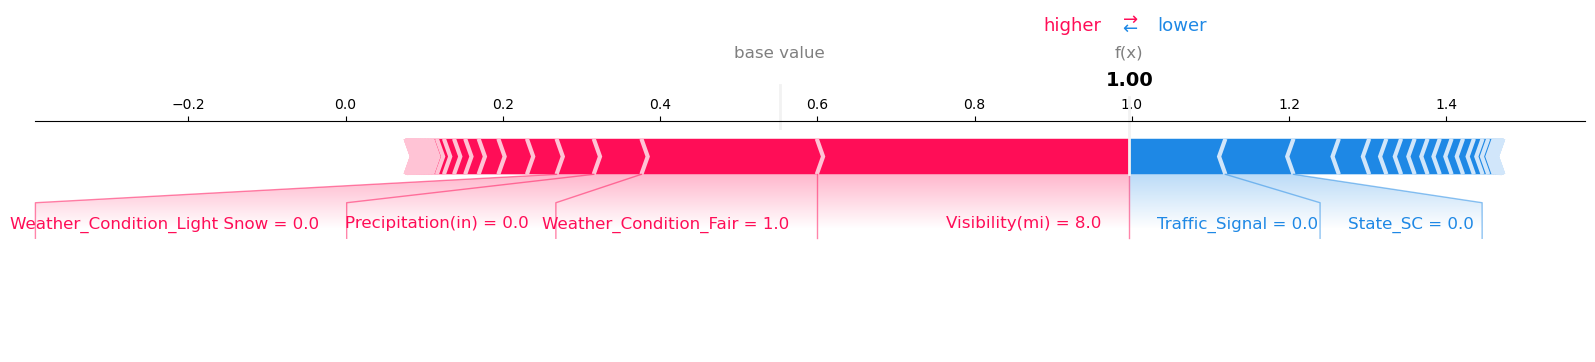

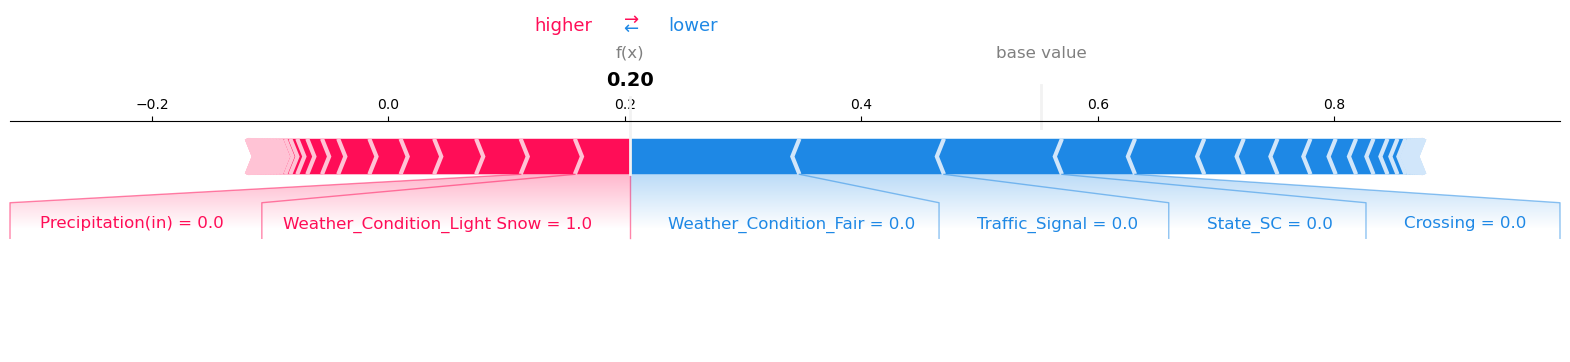

In [81]:
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test2.iloc[0,:], matplotlib=True)
shap.force_plot(explainer.expected_value[0], shap_values[0][2,:], X_test2.iloc[1,:], matplotlib=True)

So you can see here the forceplots we generated, which are showing the prediction of one specific instance of the dataset, and how will the variables influence that prediction. It will be complicated for us to trust these predictions, because we could see in the univariate analysis that the variables usually take on a very predominant value, and the other variables like Traffic Signals, Crossing or Junction or Boolean values and so often at 0. This explains why our accuracy is only 0.57 in the XgBoost model.

However, in our forceplot, we can see that having no Trafffic_Signals and no Crossing will lower the prediction and having a light_snow weather condition will make it higher, which is kinda logic.

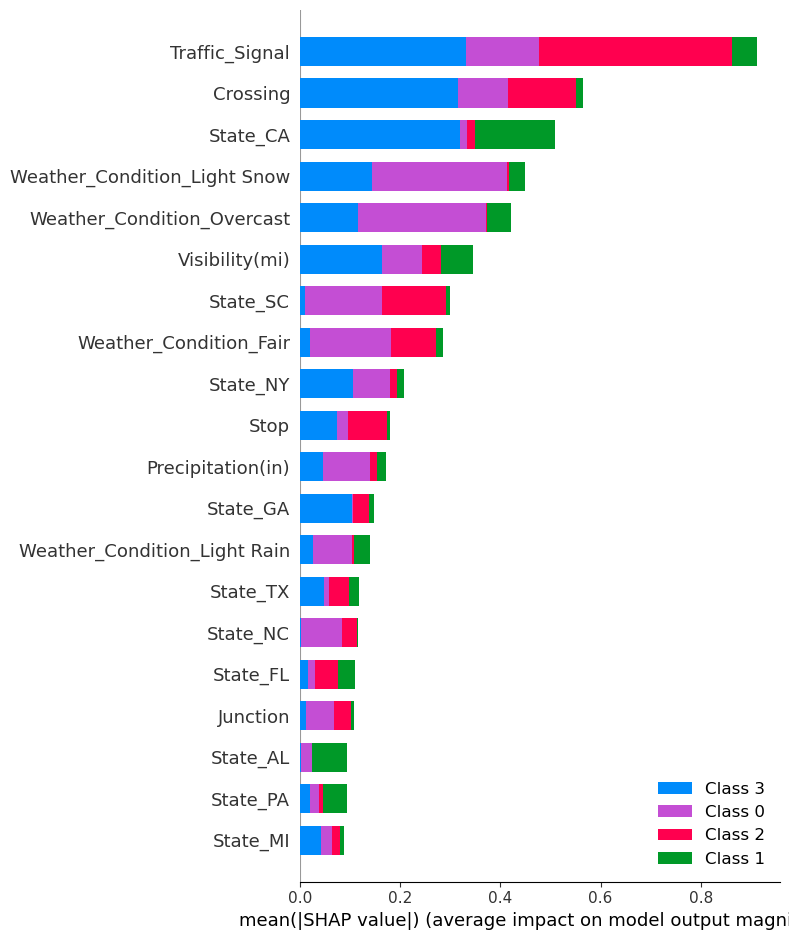

In [54]:
shap.summary_plot(shap_values, X_test2, plot_type="bar")

Now we wanted to compare our results with the linear regression ones. So now, we can see that the number of traffic signals, and the number of Crossings became the most important variables. In the linear regression, we thought that the linear relationship between severity and those variables was low meaning that doing a linear regression was not enough to determine the most impactful variables. 

Now that we have this better model, we can see that Traffic Signals and Crossing variables will mostly have an impact on the light accident, (class 1 and class 2), and less on the most severe case. \
Also, let’s not forget that Weather conditions and State that we found important in the linear regression are still important for our Xgboost model. \
And Visibility and Precipitation also appears to be impactful let’s not forget them.

Let's do the beeswarms plot, with a dataframe with the most important variables

In [55]:
important_variables = X_test2[['Precipitation(in)', 'Traffic_Signal', 'Crossing', 'Visibility(mi)']].copy()

# Ajout de la variable Severity
important_variables['Severity'] = y_test2.copy()

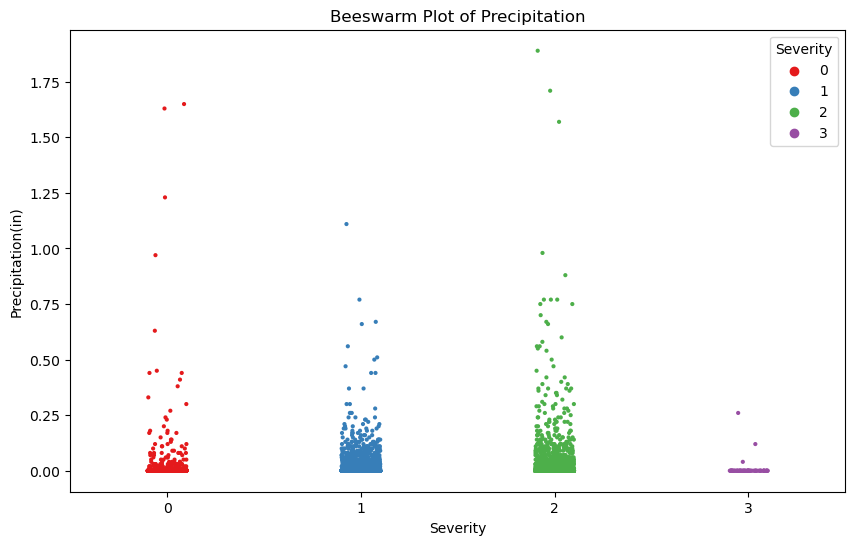

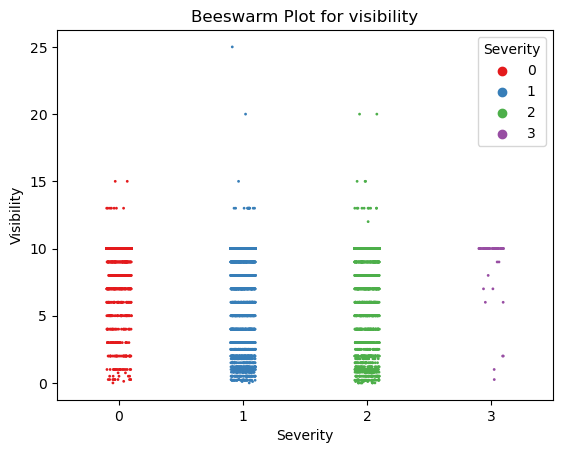

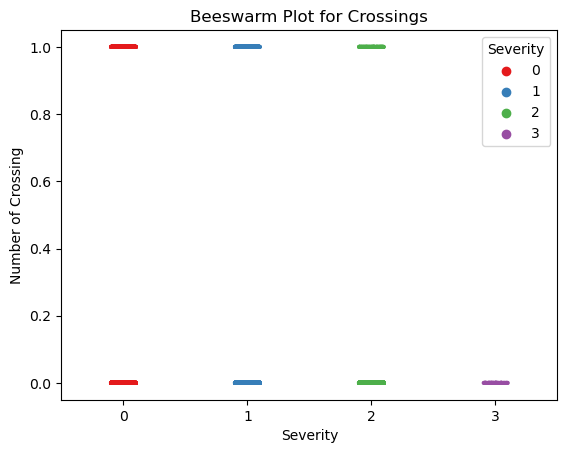

In [56]:
plt.figure(figsize=(10, 6))

# Precipitation
sns.stripplot(data=important_variables, x='Severity', y='Precipitation(in)', size=3, hue='Severity', palette='Set1')
plt.xlabel('Severity')
plt.ylabel('Precipitation(in)')
plt.title('Beeswarm Plot of Precipitation')
plt.show()

# Visibility
sns.stripplot(x='Severity', y='Visibility(mi)', data=important_variables, size=2, hue='Severity', palette='Set1')
plt.xlabel('Severity')
plt.ylabel('Visibility')
plt.title('Beeswarm Plot for visibility')
plt.show()

# Crossing
sns.stripplot(x='Severity', y='Crossing', data=important_variables, size=3, hue='Severity', palette='Set1')
plt.xlabel('Severity')
plt.ylabel('Number of Crossing')
plt.title('Beeswarm Plot for Crossings')
plt.show()

For the precipitation :
We realize that the worst severity of an accident won't be correlated to the precipitation at the moment. But for the severity 3 (class 2), the results will be more scattered.

For the visibility :
Surprisely, the most severe accident did not happen when the visibility was low. But, it was for the lighter ones.

For the Crossings:
We understand now that making a beeswarm plot with binary variables are useless, because the result won't be readable and explicit.

In these plots, we realize that we cannot use values like Traffic_Signals or Crossing that are binary. The results won't be readable and explicit. However, we've got results with Precipitation and Visibility. We are aware that these two variables were not the most impactful according to our model, but all other variables were binary, so we had no choice other than using them.

So we will be using Precipitation and Visibility in the dependance plots below :

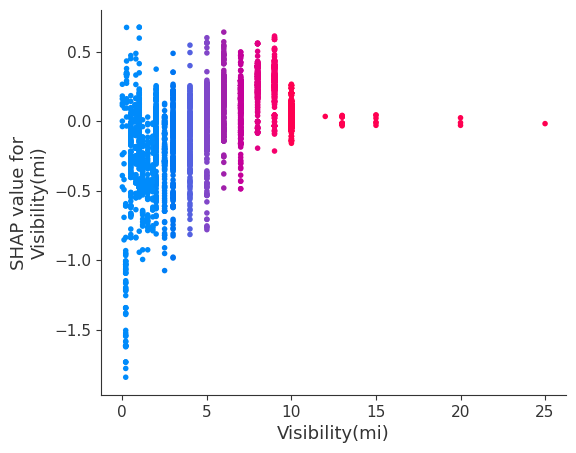

In [73]:
shap.dependence_plot(ind='Visibility(mi)', interaction_index='Visibility(mi)', shap_values=shap_values[0], features=X_test2, display_features=X_test2)


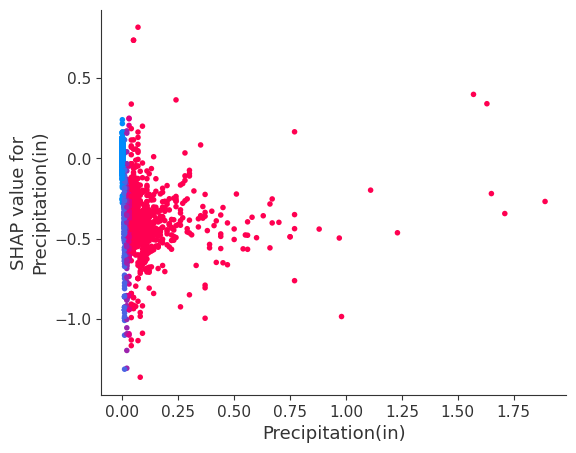

In [74]:
shap.dependence_plot(ind='Precipitation(in)', interaction_index='Precipitation(in)', shap_values=shap_values[0], features=X_test2, display_features=X_test2)

In the visibility dependance plot, we can say that the visibility negatively contributes to the severity of an accident. The less visibility there is, the less the accident will be severe. (We can explain this with the fact that people will drive slower when they can't see).

Unfortunately, our precipitation dependance plot is not pertinent.

# Question 7

In [84]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.datasets import make_blobs
import os

os.environ["OMP_NUM_THREADS"] = "1"

In [85]:
shapley_values_array = np.concatenate(shap_values, axis=0)

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
shapley_pca = pca.fit_transform(shapley_values_array)

In [86]:
print(newdf.groupby(['Severity']).count())

             ID  Source  Start_Time  End_Time  Start_Lat  Start_Lng  End_Lat  \
Severity                                                                       
0         16927   16927       16927     16927      16927      16927    16927   
1         25157   25157       25157     25157      25157      25157    25157   
2         23171   23171       23171     23171      23171      23171    23171   
3           329     329         329       329        329        329      329   

          End_Lng  Distance(mi)  State  ...  Crossing  Junction  Railway  \
Severity                                ...                                
0           16927         16927  16927  ...     16927     16927    16927   
1           25157         25157  25157  ...     25157     25157    25157   
2           23171         23171  23171  ...     23171     23171    23171   
3             329           329    329  ...       329       329      329   

          Station   Stop  Traffic_Signal  Sunrise_Sunset  Civi

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


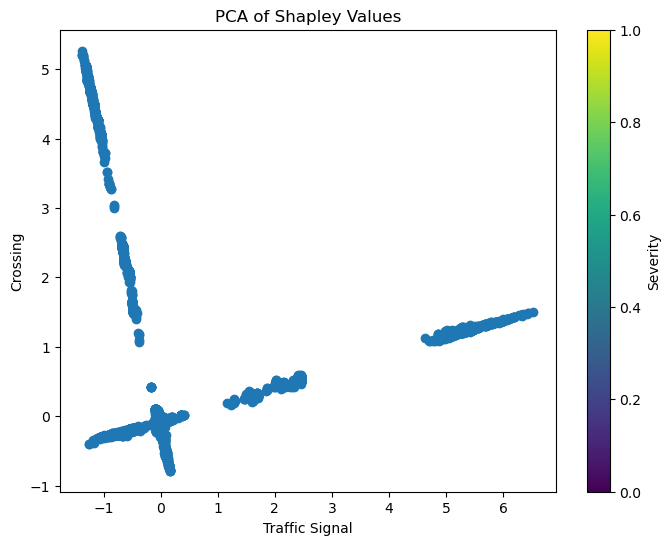

In [89]:
plt.figure(figsize=(8, 6))
plt.scatter(shapley_pca[:, 0], shapley_pca[:, 1],cmap='viridis')
plt.xlabel('Traffic Signal')
plt.ylabel('Crossing')
plt.title('PCA of Shapley Values')
plt.colorbar(label='Severity')
plt.show()

In [63]:
# Perform K-Means clustering on the PCA values
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(shapley_pca)

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


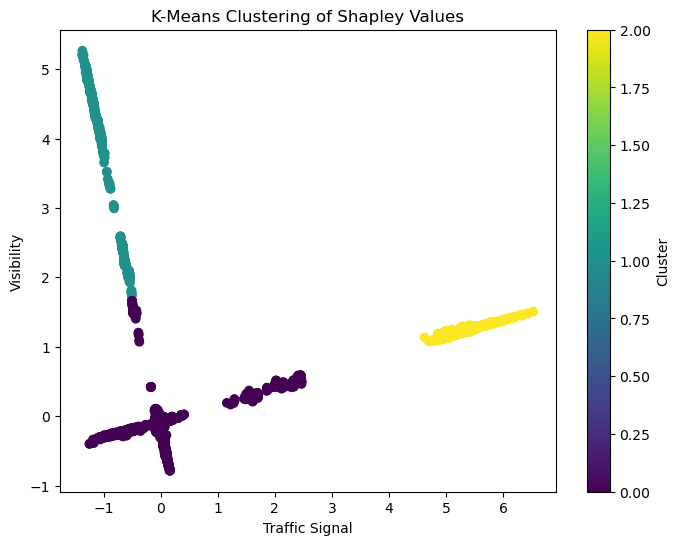

In [64]:
plt.figure(figsize=(8, 6))
plt.scatter(shapley_pca[:, 0], shapley_pca[:, 1], c=clusters, cmap='viridis')
plt.xlabel('Traffic Signal')
plt.ylabel('Crossing')
plt.title('K-Means Clustering of Shapley Values')
plt.colorbar(label='Cluster')
plt.show()

We are not really satisfied with the results we got. 

First, for the PCA, it was supposed to show the different class of severity. Unfortunately, our graph seems wrong because we couldn’t get any colors in this graph. 
And then, for the K-means clustering, these traits can be explained by the fact that the values are binary. 